In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso, HuberRegressor, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
np.random.seed(25)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,NaN,0.02496
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,20040723,NaN,20040812,C,NaN,NaN,0.05496
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,NaN,0.02496
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,NaN,0.02496
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,NaN,0.02496


In [4]:
train['hedge_value'].value_counts()

False    2437
True     1228
Name: hedge_value, dtype: int64

In [5]:
train.isnull().sum(axis=0)

portfolio_id         0
desk_id           3665
office_id            0
pf_category          0
start_date           0
sold                 2
country_code         0
euribor_rate         0
currency             0
libor_rate         474
bought               2
creation_date        0
indicator_code    5699
sell_date            0
type                 0
hedge_value       5701
status            3084
return               0
dtype: int64

In [6]:
train = train.fillna({"indicator_code": True, "hedge_value":False, "status":True, "sold": train["sold"].mean(), 
                     "libor_rate": train["libor_rate"].median(), "bought": train["bought"].mean()})
test = test.fillna({"indicator_code": True, "hedge_value":False, "status":True, "sold": test["sold"].mean(), 
                     "libor_rate": test["libor_rate"].median(), "bought": test["bought"].mean()})

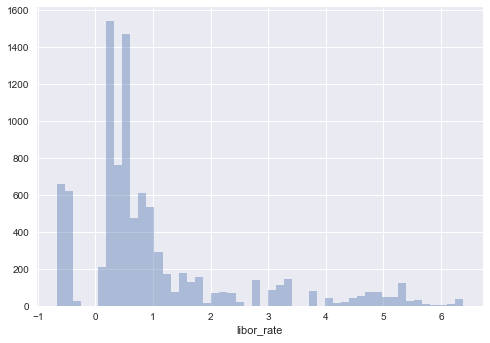

In [7]:
sns.distplot(train['libor_rate'], kde=False)
#sns.distplot(train['libor_rate'] , fit=norm);

# Feature Engineering

In [8]:
train['start_date'] = pd.to_datetime(train['start_date'].astype(str), format='%Y%m%d')
train['creation_date'] = pd.to_datetime(train['creation_date'].astype(str), format='%Y%m%d')
train['sell_date'] = pd.to_datetime(train['sell_date'].astype(str), format='%Y%m%d')

test['start_date'] = pd.to_datetime(test['start_date'].astype(str), format='%Y%m%d')
test['creation_date'] = pd.to_datetime(test['creation_date'].astype(str), format='%Y%m%d')
test['sell_date'] = pd.to_datetime(test['sell_date'].astype(str), format='%Y%m%d')

In [10]:
train['portfolio_duration'] = train['sell_date'] .subtract( train['start_date'])
test['portfolio_duration'] = test['sell_date'] .subtract( test['start_date'])

train['portfolio_duration'] = train['portfolio_duration'] .divide( np.timedelta64(1, 'D'))
test['portfolio_duration'] = test['portfolio_duration'] .divide( np.timedelta64(1, 'D'))

In [11]:
train['portfolio_creation_diff'] = train['creation_date'] .subtract( train['start_date'])
test['portfolio_creation_diff'] = test['creation_date'] .subtract( test['start_date'])

train['portfolio_creation_diff'] = train['portfolio_creation_diff'] .divide( np.timedelta64(1, 'D'))
test['portfolio_creation_diff'] = test['portfolio_creation_diff'] .divide( np.timedelta64(1, 'D'))

In [12]:
train['portfolio_trading_duration'] = train['sell_date'] .subtract( train['creation_date'])
test['portfolio_trading_duration'] = test['sell_date'] .subtract( test['creation_date'])

train['portfolio_trading_duration'] = train['portfolio_trading_duration'] .divide( np.timedelta64(1, 'D'))
test['portfolio_trading_duration'] = test['portfolio_trading_duration'] .divide( np.timedelta64(1, 'D'))

In [13]:
train['profit'] = train['sold'] - train['bought']
test['profit'] = test['sold'] - test['bought']

In [14]:
train['rate_diff'] = train['euribor_rate'] - train['libor_rate']
test['rate_diff'] = test['euribor_rate'] - test['libor_rate']

In [15]:
train.shape

(9366, 23)

In [16]:
#standardizing data
return_scaled = StandardScaler().fit_transform(train['sold'][:,np.newaxis]);
low_range = return_scaled[return_scaled[:,0].argsort()][:10]
high_range= return_scaled[return_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.52897771]
 [-0.52892066]
 [-0.52892066]
 [-0.52892066]
 [-0.52892066]
 [-0.52892066]
 [-0.52892066]
 [-0.52892066]
 [-0.52892066]
 [-0.52892066]]

outer range (high) of the distribution:
[[  6.70373826]
 [  6.77692488]
 [  6.84846242]
 [  7.06363997]
 [  7.09590805]
 [  7.49545013]
 [  7.68714131]
 [  8.0230317 ]
 [  8.66864423]
 [ 67.94438699]]


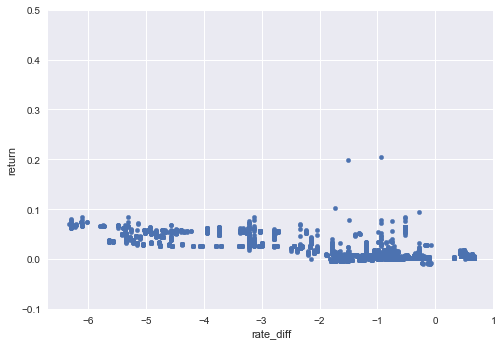

In [17]:
#bivariate analysis return/portfolio_duration
var = 'rate_diff'
data = pd.concat([train['return'], train[var]], axis=1)
data.plot.scatter(x=var, y='return', ylim=(-0.1,.5));

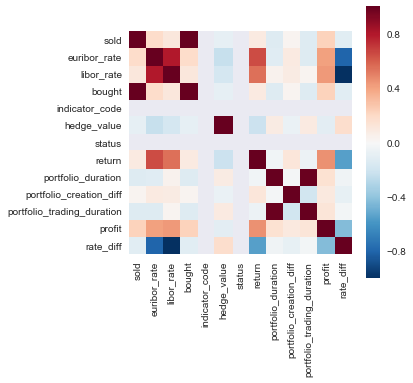

In [18]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

In [19]:
# One-hot encoding
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
train["office_id"] = lb_make.fit_transform(train["office_id"])
train["pf_category"] = lb_make.fit_transform(train["pf_category"])
train["country_code"] = lb_make.fit_transform(train["country_code"])
train["currency"] = lb_make.fit_transform(train["currency"])
train["indicator_code"] = lb_make.fit_transform(train["indicator_code"])
train["type"] = lb_make.fit_transform(train["type"])
train["hedge_value"] = lb_make.fit_transform(train["hedge_value"])
train["status"] = lb_make.fit_transform(train["status"])

test["office_id"] = lb_make.fit_transform(test["office_id"])
test["pf_category"] = lb_make.fit_transform(test["pf_category"])
test["country_code"] = lb_make.fit_transform(test["country_code"])
test["currency"] = lb_make.fit_transform(test["currency"])
test["indicator_code"] = lb_make.fit_transform(test["indicator_code"])
test["type"] = lb_make.fit_transform(test["type"])
test["hedge_value"] = lb_make.fit_transform(test["hedge_value"])
test["status"] = lb_make.fit_transform(test["status"])



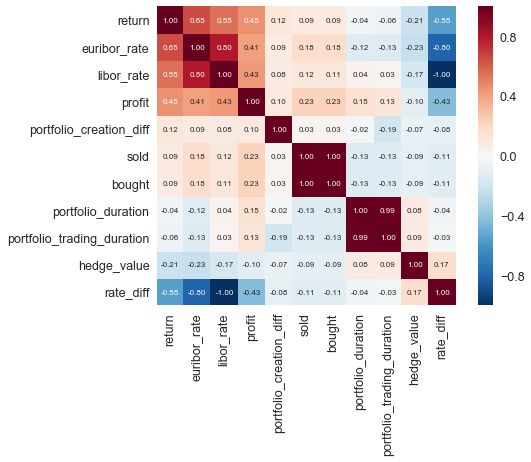

In [20]:
#saleprice correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'return')['return'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [21]:
# train['sold'] = np.log1p(train["sold"])
# train['bought'] = np.log1p(train["bought"])

# test['sold'] = np.log1p(test["sold"])
# test['bought'] = np.log1p(test["bought"])

train.columns

Index(['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date',
       'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate',
       'bought', 'creation_date', 'indicator_code', 'sell_date', 'type',
       'hedge_value', 'status', 'return', 'portfolio_duration',
       'portfolio_creation_diff', 'portfolio_trading_duration', 'profit',
       'rate_diff'],
      dtype='object')

In [22]:
feature_names = [x for x in train.columns if x not in ['status','indicator_code','portfolio_id','desk_id','return','sell_date','creation_date','start_date']]
target = train['return']

In [23]:
len(feature_names)

15

In [24]:
from catboost import CatBoostRegressor

model_catboost = CatBoostRegressor(l2_leaf_reg=3,rsm=1,eval_metric='R2',learning_rate=0.3,verbose=True, iterations=100,depth=16)

model_catboost.fit(train[feature_names], target, cat_features=[0, 1, 3, 5, 8])

pred = model_catboost.predict(test[feature_names])

pred[:10]

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


Borders generated
0:	learn 0.2820762758passed: 0.771 sec	total: 897ms	remaining: 1m 28s
1:	learn 0.494560508passed: 1.53 sec	total: 2.42s	remaining: 1m 58s
2:	learn 0.6148844828passed: 0.0374 sec	total: 2.46s	remaining: 1m 19s
3:	

KeyboardInterrupt: 

In [ ]:
## make submission
sub = pd.DataFrame()
sub['portfolio_id'] = test['portfolio_id']
sub['return'] = pred
sub.to_csv('annual_returns.csv', index=False)